# Week 3 Analysis Notebook

Goal now is to work towards combining output from last two weeks into making a prediction for the observed cosmic SED. Essentially means accouting for fact that higher $z$ galaxies will be dimmer. Aiming to do this through a lightcone using Chris Lovell's lightcone generation code for SIMBA. Then finally sum the apparent magnitudes as is already being done to get total SED.

In [2]:
from pathlib import Path
import re
import numpy as np
import h5py
import fsps
import caesar
import astropy.units as u
from astropy.constants import c
import matplotlib.pyplot as plt

import sys
# sys.path.insert(0, '../src')
# from week_2_funcs import get_redshift, list_snapshots, compute_summed_sed_from_appmags, compute_summed_sed_from_absmags, get_stellar_mass_bins, classify_galaxies
lightcone_path = Path('../src/lightcone').resolve()
sys.path.insert(0, str(lightcone_path.parent))
from lightcone.generate_lightcone import generate_lightcone, OUTPUT_DIR


CAT_DIR = Path("/home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256")

yt : [INFO     ] 2026-01-27 16:15:29,900 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_151.hdf5
yt : [INFO     ] 2026-01-27 16:15:29,912 Found 7567 halos
yt : [INFO     ] 2026-01-27 16:15:29,915 Found 920 galaxies
yt : [INFO     ] 2026-01-27 16:15:29,915 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_150.hdf5
yt : [INFO     ] 2026-01-27 16:15:29,918 Found 15890 halos
yt : [INFO     ] 2026-01-27 16:15:29,920 Found 1152 galaxies
yt : [INFO     ] 2026-01-27 16:15:29,921 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_149.hdf5
yt : [INFO     ] 2026-01-27 16:15:29,924 Found 15983 halos
yt : [INFO     ] 2026-01-27 16:15:29,925 Found 1145 galaxies
yt : [INFO     ] 2026-01-27 16:15:29,926 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_148.hdf5
yt : [INFO

Skipping snap 9 (no halo data)
Skipping snap 8 (no halo data)
Skipping snap 7 (no halo data)
Skipping snap 6 (no halo data)
Skipping snap 5 (no halo data)
Skipping snap 4 (no halo data)
Skipping snap 3 (no halo data)
Skipping snap 2 (no halo data)
Skipping snap 1 (no halo data)

Using 141 snapshots
Redshift range: 0.00 to 13.20

Processing snap 151, z=0.000


yt : [INFO     ] 2026-01-27 16:15:31,609 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_150.hdf5
yt : [INFO     ] 2026-01-27 16:15:31,612 Found 15890 halos
yt : [INFO     ] 2026-01-27 16:15:31,613 Found 1152 galaxies
yt : [INFO     ] 2026-01-27 16:15:31,631 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_149.hdf5
yt : [INFO     ] 2026-01-27 16:15:31,636 Found 15983 halos
yt : [INFO     ] 2026-01-27 16:15:31,637 Found 1145 galaxies
yt : [INFO     ] 2026-01-27 16:15:31,655 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_148.hdf5
yt : [INFO     ] 2026-01-27 16:15:31,665 Found 7647 halos
yt : [INFO     ] 2026-01-27 16:15:31,668 Found 901 galaxies
yt : [INFO     ] 2026-01-27 16:15:31,688 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_147.hdf5
yt : [INFO

  Selected 0 of 920 galaxies

Processing snap 150, z=0.017
  Selected 0 of 1152 galaxies

Processing snap 149, z=0.034
  Selected 0 of 1145 galaxies

Processing snap 148, z=0.051
  Selected 3 of 901 galaxies

Processing snap 147, z=0.068
  Selected 34 of 911 galaxies

Processing snap 146, z=0.085
  Selected 3 of 891 galaxies

Processing snap 145, z=0.102


yt : [INFO     ] 2026-01-27 16:15:31,963 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_144.hdf5
yt : [INFO     ] 2026-01-27 16:15:31,970 Found 7687 halos
yt : [INFO     ] 2026-01-27 16:15:31,973 Found 889 galaxies
yt : [INFO     ] 2026-01-27 16:15:32,072 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_143.hdf5
yt : [INFO     ] 2026-01-27 16:15:32,081 Found 7733 halos
yt : [INFO     ] 2026-01-27 16:15:32,084 Found 875 galaxies
yt : [INFO     ] 2026-01-27 16:15:32,120 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_142.hdf5
yt : [INFO     ] 2026-01-27 16:15:32,127 Found 7735 halos
yt : [INFO     ] 2026-01-27 16:15:32,129 Found 885 galaxies


  Selected 17 of 886 galaxies

Processing snap 144, z=0.120
  Selected 121 of 889 galaxies

Processing snap 143, z=0.138
  Selected 32 of 875 galaxies

Processing snap 142, z=0.156
  Selected 53 of 885 galaxies


yt : [INFO     ] 2026-01-27 16:15:32,179 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_141.hdf5
yt : [INFO     ] 2026-01-27 16:15:32,187 Found 7673 halos
yt : [INFO     ] 2026-01-27 16:15:32,189 Found 877 galaxies
yt : [INFO     ] 2026-01-27 16:15:32,304 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_140.hdf5
yt : [INFO     ] 2026-01-27 16:15:32,312 Found 7727 halos
yt : [INFO     ] 2026-01-27 16:15:32,314 Found 861 galaxies



Processing snap 141, z=0.174
  Selected 162 of 877 galaxies

Processing snap 140, z=0.192
  Selected 141 of 861 galaxies


yt : [INFO     ] 2026-01-27 16:15:32,419 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_139.hdf5
yt : [INFO     ] 2026-01-27 16:15:32,427 Found 7769 halos
yt : [INFO     ] 2026-01-27 16:15:32,430 Found 870 galaxies



Processing snap 139, z=0.210
  Selected 385 of 870 galaxies


yt : [INFO     ] 2026-01-27 16:15:32,697 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_138.hdf5
yt : [INFO     ] 2026-01-27 16:15:32,705 Found 7755 halos
yt : [INFO     ] 2026-01-27 16:15:32,706 Found 851 galaxies
yt : [INFO     ] 2026-01-27 16:15:32,827 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_137.hdf5
yt : [INFO     ] 2026-01-27 16:15:32,834 Found 7848 halos
yt : [INFO     ] 2026-01-27 16:15:32,836 Found 841 galaxies



Processing snap 138, z=0.229
  Selected 174 of 851 galaxies

Processing snap 137, z=0.248
  Selected 458 of 841 galaxies


yt : [INFO     ] 2026-01-27 16:15:33,309 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_136.hdf5
yt : [INFO     ] 2026-01-27 16:15:33,317 Found 7856 halos
yt : [INFO     ] 2026-01-27 16:15:33,319 Found 837 galaxies



Processing snap 136, z=0.267
  Selected 387 of 837 galaxies


yt : [INFO     ] 2026-01-27 16:15:33,576 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_135.hdf5
yt : [INFO     ] 2026-01-27 16:15:33,582 Found 7869 halos
yt : [INFO     ] 2026-01-27 16:15:33,584 Found 822 galaxies



Processing snap 135, z=0.286
  Selected 350 of 822 galaxies


yt : [INFO     ] 2026-01-27 16:15:33,812 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_134.hdf5
yt : [INFO     ] 2026-01-27 16:15:33,820 Found 7828 halos
yt : [INFO     ] 2026-01-27 16:15:33,823 Found 810 galaxies



Processing snap 134, z=0.305
  Selected 552 of 810 galaxies


yt : [INFO     ] 2026-01-27 16:15:34,176 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_133.hdf5
yt : [INFO     ] 2026-01-27 16:15:34,182 Found 7883 halos
yt : [INFO     ] 2026-01-27 16:15:34,184 Found 813 galaxies



Processing snap 133, z=0.325
  Selected 596 of 813 galaxies


yt : [INFO     ] 2026-01-27 16:15:34,574 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_132.hdf5
yt : [INFO     ] 2026-01-27 16:15:34,580 Found 7894 halos
yt : [INFO     ] 2026-01-27 16:15:34,582 Found 796 galaxies



Processing snap 132, z=0.345
  Selected 499 of 796 galaxies


yt : [INFO     ] 2026-01-27 16:15:34,933 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_131.hdf5
yt : [INFO     ] 2026-01-27 16:15:34,939 Found 7946 halos
yt : [INFO     ] 2026-01-27 16:15:34,941 Found 786 galaxies



Processing snap 131, z=0.365
  Selected 506 of 786 galaxies


yt : [INFO     ] 2026-01-27 16:15:35,254 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_130.hdf5
yt : [INFO     ] 2026-01-27 16:15:35,261 Found 7969 halos
yt : [INFO     ] 2026-01-27 16:15:35,262 Found 799 galaxies



Processing snap 130, z=0.385
  Selected 683 of 799 galaxies


yt : [INFO     ] 2026-01-27 16:15:35,673 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_129.hdf5
yt : [INFO     ] 2026-01-27 16:15:35,680 Found 7907 halos
yt : [INFO     ] 2026-01-27 16:15:35,682 Found 788 galaxies



Processing snap 129, z=0.406
  Selected 561 of 788 galaxies


yt : [INFO     ] 2026-01-27 16:15:36,024 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_128.hdf5
yt : [INFO     ] 2026-01-27 16:15:36,031 Found 7985 halos
yt : [INFO     ] 2026-01-27 16:15:36,033 Found 779 galaxies



Processing snap 128, z=0.427
  Selected 551 of 779 galaxies


yt : [INFO     ] 2026-01-27 16:15:36,379 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_127.hdf5
yt : [INFO     ] 2026-01-27 16:15:36,386 Found 8071 halos
yt : [INFO     ] 2026-01-27 16:15:36,388 Found 782 galaxies



Processing snap 127, z=0.448
  Selected 581 of 782 galaxies


yt : [INFO     ] 2026-01-27 16:15:36,958 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_126.hdf5
yt : [INFO     ] 2026-01-27 16:15:36,965 Found 8083 halos
yt : [INFO     ] 2026-01-27 16:15:36,967 Found 764 galaxies



Processing snap 126, z=0.469
  Selected 674 of 764 galaxies


yt : [INFO     ] 2026-01-27 16:15:37,411 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_125.hdf5
yt : [INFO     ] 2026-01-27 16:15:37,418 Found 8122 halos
yt : [INFO     ] 2026-01-27 16:15:37,419 Found 767 galaxies



Processing snap 125, z=0.490
  Selected 735 of 767 galaxies


yt : [INFO     ] 2026-01-27 16:15:37,850 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_124.hdf5
yt : [INFO     ] 2026-01-27 16:15:37,856 Found 8154 halos
yt : [INFO     ] 2026-01-27 16:15:37,858 Found 759 galaxies



Processing snap 124, z=0.512
  Selected 754 of 759 galaxies


yt : [INFO     ] 2026-01-27 16:15:38,319 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_123.hdf5
yt : [INFO     ] 2026-01-27 16:15:38,326 Found 8172 halos
yt : [INFO     ] 2026-01-27 16:15:38,328 Found 748 galaxies



Processing snap 123, z=0.534
  Selected 728 of 748 galaxies


yt : [INFO     ] 2026-01-27 16:15:38,787 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_122.hdf5
yt : [INFO     ] 2026-01-27 16:15:38,794 Found 8169 halos
yt : [INFO     ] 2026-01-27 16:15:38,796 Found 749 galaxies



Processing snap 122, z=0.557
  Selected 749 of 749 galaxies


yt : [INFO     ] 2026-01-27 16:15:39,294 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_121.hdf5
yt : [INFO     ] 2026-01-27 16:15:39,302 Found 8186 halos
yt : [INFO     ] 2026-01-27 16:15:39,303 Found 752 galaxies



Processing snap 121, z=0.580
  Selected 752 of 752 galaxies


yt : [INFO     ] 2026-01-27 16:15:39,788 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_120.hdf5
yt : [INFO     ] 2026-01-27 16:15:39,795 Found 8215 halos
yt : [INFO     ] 2026-01-27 16:15:39,797 Found 725 galaxies



Processing snap 120, z=0.603
  Selected 725 of 725 galaxies


yt : [INFO     ] 2026-01-27 16:15:40,232 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_119.hdf5
yt : [INFO     ] 2026-01-27 16:15:40,239 Found 8258 halos
yt : [INFO     ] 2026-01-27 16:15:40,241 Found 725 galaxies



Processing snap 119, z=0.626
  Selected 725 of 725 galaxies


yt : [INFO     ] 2026-01-27 16:15:40,692 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_118.hdf5
yt : [INFO     ] 2026-01-27 16:15:40,699 Found 8313 halos
yt : [INFO     ] 2026-01-27 16:15:40,700 Found 722 galaxies



Processing snap 118, z=0.650
  Selected 722 of 722 galaxies


yt : [INFO     ] 2026-01-27 16:15:41,136 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_117.hdf5
yt : [INFO     ] 2026-01-27 16:15:41,143 Found 8336 halos
yt : [INFO     ] 2026-01-27 16:15:41,145 Found 716 galaxies



Processing snap 117, z=0.674
  Selected 716 of 716 galaxies


yt : [INFO     ] 2026-01-27 16:15:41,578 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_116.hdf5
yt : [INFO     ] 2026-01-27 16:15:41,586 Found 8346 halos
yt : [INFO     ] 2026-01-27 16:15:41,588 Found 700 galaxies



Processing snap 116, z=0.698
  Selected 700 of 700 galaxies


yt : [INFO     ] 2026-01-27 16:15:42,023 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_115.hdf5
yt : [INFO     ] 2026-01-27 16:15:42,030 Found 8374 halos
yt : [INFO     ] 2026-01-27 16:15:42,033 Found 697 galaxies



Processing snap 115, z=0.723
  Selected 697 of 697 galaxies


yt : [INFO     ] 2026-01-27 16:15:42,463 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_114.hdf5
yt : [INFO     ] 2026-01-27 16:15:42,470 Found 8429 halos
yt : [INFO     ] 2026-01-27 16:15:42,472 Found 693 galaxies



Processing snap 114, z=0.748
  Selected 693 of 693 galaxies


yt : [INFO     ] 2026-01-27 16:15:43,133 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_113.hdf5
yt : [INFO     ] 2026-01-27 16:15:43,140 Found 8450 halos
yt : [INFO     ] 2026-01-27 16:15:43,142 Found 697 galaxies



Processing snap 113, z=0.773
  Selected 697 of 697 galaxies


yt : [INFO     ] 2026-01-27 16:15:43,570 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_112.hdf5
yt : [INFO     ] 2026-01-27 16:15:43,578 Found 8459 halos
yt : [INFO     ] 2026-01-27 16:15:43,580 Found 701 galaxies



Processing snap 112, z=0.799
  Selected 701 of 701 galaxies


yt : [INFO     ] 2026-01-27 16:15:43,980 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_111.hdf5
yt : [INFO     ] 2026-01-27 16:15:43,987 Found 8474 halos
yt : [INFO     ] 2026-01-27 16:15:43,988 Found 684 galaxies



Processing snap 111, z=0.826
  Selected 684 of 684 galaxies


yt : [INFO     ] 2026-01-27 16:15:44,389 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_110.hdf5
yt : [INFO     ] 2026-01-27 16:15:44,398 Found 8468 halos
yt : [INFO     ] 2026-01-27 16:15:44,400 Found 686 galaxies



Processing snap 110, z=0.852
  Selected 686 of 686 galaxies


yt : [INFO     ] 2026-01-27 16:15:44,826 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_109.hdf5
yt : [INFO     ] 2026-01-27 16:15:44,833 Found 8520 halos
yt : [INFO     ] 2026-01-27 16:15:44,834 Found 676 galaxies



Processing snap 109, z=0.880
  Selected 676 of 676 galaxies


yt : [INFO     ] 2026-01-27 16:15:45,249 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_108.hdf5
yt : [INFO     ] 2026-01-27 16:15:45,255 Found 8535 halos
yt : [INFO     ] 2026-01-27 16:15:45,257 Found 675 galaxies



Processing snap 108, z=0.907
  Selected 675 of 675 galaxies


yt : [INFO     ] 2026-01-27 16:15:45,679 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_107.hdf5
yt : [INFO     ] 2026-01-27 16:15:45,686 Found 8544 halos
yt : [INFO     ] 2026-01-27 16:15:45,688 Found 673 galaxies



Processing snap 107, z=0.935
  Selected 673 of 673 galaxies


yt : [INFO     ] 2026-01-27 16:15:46,103 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_106.hdf5
yt : [INFO     ] 2026-01-27 16:15:46,110 Found 8641 halos
yt : [INFO     ] 2026-01-27 16:15:46,112 Found 668 galaxies



Processing snap 106, z=0.964
  Selected 668 of 668 galaxies


yt : [INFO     ] 2026-01-27 16:15:46,522 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_105.hdf5
yt : [INFO     ] 2026-01-27 16:15:46,530 Found 8666 halos
yt : [INFO     ] 2026-01-27 16:15:46,532 Found 655 galaxies



Processing snap 105, z=0.993
  Selected 655 of 655 galaxies


yt : [INFO     ] 2026-01-27 16:15:46,931 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_104.hdf5
yt : [INFO     ] 2026-01-27 16:15:46,938 Found 8689 halos
yt : [INFO     ] 2026-01-27 16:15:46,939 Found 665 galaxies



Processing snap 104, z=1.022
  Selected 665 of 665 galaxies


yt : [INFO     ] 2026-01-27 16:15:47,335 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_103.hdf5
yt : [INFO     ] 2026-01-27 16:15:47,342 Found 8700 halos
yt : [INFO     ] 2026-01-27 16:15:47,344 Found 661 galaxies



Processing snap 103, z=1.052
  Selected 661 of 661 galaxies


yt : [INFO     ] 2026-01-27 16:15:47,737 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_102.hdf5
yt : [INFO     ] 2026-01-27 16:15:47,743 Found 8714 halos
yt : [INFO     ] 2026-01-27 16:15:47,745 Found 664 galaxies



Processing snap 102, z=1.083
  Selected 664 of 664 galaxies


yt : [INFO     ] 2026-01-27 16:15:48,151 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_101.hdf5
yt : [INFO     ] 2026-01-27 16:15:48,157 Found 8743 halos
yt : [INFO     ] 2026-01-27 16:15:48,159 Found 673 galaxies



Processing snap 101, z=1.114
  Selected 673 of 673 galaxies


yt : [INFO     ] 2026-01-27 16:15:48,555 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_100.hdf5
yt : [INFO     ] 2026-01-27 16:15:48,562 Found 8752 halos
yt : [INFO     ] 2026-01-27 16:15:48,563 Found 656 galaxies



Processing snap 100, z=1.145
  Selected 656 of 656 galaxies


yt : [INFO     ] 2026-01-27 16:15:48,970 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_099.hdf5
yt : [INFO     ] 2026-01-27 16:15:48,976 Found 8781 halos
yt : [INFO     ] 2026-01-27 16:15:48,978 Found 648 galaxies



Processing snap 99, z=1.178
  Selected 648 of 648 galaxies


yt : [INFO     ] 2026-01-27 16:15:49,376 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_098.hdf5
yt : [INFO     ] 2026-01-27 16:15:49,384 Found 8779 halos
yt : [INFO     ] 2026-01-27 16:15:49,387 Found 647 galaxies



Processing snap 98, z=1.211
  Selected 647 of 647 galaxies


yt : [INFO     ] 2026-01-27 16:15:49,782 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_097.hdf5
yt : [INFO     ] 2026-01-27 16:15:49,791 Found 8795 halos
yt : [INFO     ] 2026-01-27 16:15:49,793 Found 642 galaxies



Processing snap 97, z=1.244
  Selected 642 of 642 galaxies


yt : [INFO     ] 2026-01-27 16:15:50,187 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_096.hdf5
yt : [INFO     ] 2026-01-27 16:15:50,194 Found 8818 halos
yt : [INFO     ] 2026-01-27 16:15:50,195 Found 638 galaxies



Processing snap 96, z=1.278
  Selected 638 of 638 galaxies


yt : [INFO     ] 2026-01-27 16:15:50,589 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_095.hdf5
yt : [INFO     ] 2026-01-27 16:15:50,597 Found 8769 halos
yt : [INFO     ] 2026-01-27 16:15:50,599 Found 633 galaxies



Processing snap 95, z=1.313
  Selected 633 of 633 galaxies


yt : [INFO     ] 2026-01-27 16:15:51,255 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_094.hdf5
yt : [INFO     ] 2026-01-27 16:15:51,262 Found 8803 halos
yt : [INFO     ] 2026-01-27 16:15:51,263 Found 641 galaxies



Processing snap 94, z=1.348
  Selected 641 of 641 galaxies


yt : [INFO     ] 2026-01-27 16:15:51,671 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_093.hdf5
yt : [INFO     ] 2026-01-27 16:15:51,678 Found 8817 halos
yt : [INFO     ] 2026-01-27 16:15:51,680 Found 642 galaxies



Processing snap 93, z=1.384
  Selected 642 of 642 galaxies


yt : [INFO     ] 2026-01-27 16:15:52,072 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_092.hdf5
yt : [INFO     ] 2026-01-27 16:15:52,079 Found 8875 halos
yt : [INFO     ] 2026-01-27 16:15:52,081 Found 620 galaxies



Processing snap 92, z=1.421
  Selected 620 of 620 galaxies


yt : [INFO     ] 2026-01-27 16:15:52,453 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_091.hdf5
yt : [INFO     ] 2026-01-27 16:15:52,462 Found 8847 halos
yt : [INFO     ] 2026-01-27 16:15:52,463 Found 601 galaxies



Processing snap 91, z=1.458
  Selected 601 of 601 galaxies


yt : [INFO     ] 2026-01-27 16:15:52,831 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_090.hdf5
yt : [INFO     ] 2026-01-27 16:15:52,839 Found 8877 halos
yt : [INFO     ] 2026-01-27 16:15:52,841 Found 610 galaxies



Processing snap 90, z=1.497
  Selected 610 of 610 galaxies


yt : [INFO     ] 2026-01-27 16:15:53,208 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_089.hdf5
yt : [INFO     ] 2026-01-27 16:15:53,215 Found 8913 halos
yt : [INFO     ] 2026-01-27 16:15:53,217 Found 603 galaxies



Processing snap 89, z=1.536
  Selected 603 of 603 galaxies


yt : [INFO     ] 2026-01-27 16:15:53,590 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_088.hdf5
yt : [INFO     ] 2026-01-27 16:15:53,597 Found 8836 halos
yt : [INFO     ] 2026-01-27 16:15:53,598 Found 594 galaxies



Processing snap 88, z=1.576
  Selected 594 of 594 galaxies


yt : [INFO     ] 2026-01-27 16:15:53,953 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_087.hdf5
yt : [INFO     ] 2026-01-27 16:15:53,959 Found 8890 halos
yt : [INFO     ] 2026-01-27 16:15:53,961 Found 591 galaxies



Processing snap 87, z=1.616
  Selected 591 of 591 galaxies


yt : [INFO     ] 2026-01-27 16:15:54,315 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_086.hdf5
yt : [INFO     ] 2026-01-27 16:15:54,322 Found 8892 halos
yt : [INFO     ] 2026-01-27 16:15:54,323 Found 569 galaxies



Processing snap 86, z=1.658
  Selected 569 of 569 galaxies


yt : [INFO     ] 2026-01-27 16:15:54,660 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_085.hdf5
yt : [INFO     ] 2026-01-27 16:15:54,667 Found 8903 halos
yt : [INFO     ] 2026-01-27 16:15:54,668 Found 574 galaxies



Processing snap 85, z=1.700
  Selected 574 of 574 galaxies


yt : [INFO     ] 2026-01-27 16:15:55,012 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_084.hdf5
yt : [INFO     ] 2026-01-27 16:15:55,019 Found 8869 halos
yt : [INFO     ] 2026-01-27 16:15:55,021 Found 549 galaxies



Processing snap 84, z=1.744
  Selected 549 of 549 galaxies


yt : [INFO     ] 2026-01-27 16:15:55,348 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_083.hdf5
yt : [INFO     ] 2026-01-27 16:15:55,355 Found 8905 halos
yt : [INFO     ] 2026-01-27 16:15:55,356 Found 551 galaxies



Processing snap 83, z=1.788
  Selected 551 of 551 galaxies


yt : [INFO     ] 2026-01-27 16:15:55,714 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_082.hdf5
yt : [INFO     ] 2026-01-27 16:15:55,722 Found 8908 halos
yt : [INFO     ] 2026-01-27 16:15:55,723 Found 555 galaxies



Processing snap 82, z=1.833
  Selected 555 of 555 galaxies


yt : [INFO     ] 2026-01-27 16:15:56,064 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_081.hdf5
yt : [INFO     ] 2026-01-27 16:15:56,071 Found 8880 halos
yt : [INFO     ] 2026-01-27 16:15:56,073 Found 539 galaxies



Processing snap 81, z=1.879
  Selected 539 of 539 galaxies


yt : [INFO     ] 2026-01-27 16:15:56,406 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_080.hdf5
yt : [INFO     ] 2026-01-27 16:15:56,414 Found 8878 halos
yt : [INFO     ] 2026-01-27 16:15:56,416 Found 536 galaxies



Processing snap 80, z=1.927
  Selected 536 of 536 galaxies


yt : [INFO     ] 2026-01-27 16:15:56,741 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_079.hdf5
yt : [INFO     ] 2026-01-27 16:15:56,750 Found 8900 halos
yt : [INFO     ] 2026-01-27 16:15:56,752 Found 519 galaxies



Processing snap 79, z=1.975
  Selected 519 of 519 galaxies


yt : [INFO     ] 2026-01-27 16:15:57,068 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_078.hdf5
yt : [INFO     ] 2026-01-27 16:15:57,076 Found 8893 halos
yt : [INFO     ] 2026-01-27 16:15:57,078 Found 530 galaxies



Processing snap 78, z=2.025
  Selected 530 of 530 galaxies


yt : [INFO     ] 2026-01-27 16:15:57,431 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_077.hdf5
yt : [INFO     ] 2026-01-27 16:15:57,439 Found 8898 halos
yt : [INFO     ] 2026-01-27 16:15:57,441 Found 507 galaxies



Processing snap 77, z=2.075
  Selected 507 of 507 galaxies


yt : [INFO     ] 2026-01-27 16:15:57,754 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_076.hdf5
yt : [INFO     ] 2026-01-27 16:15:57,761 Found 8869 halos
yt : [INFO     ] 2026-01-27 16:15:57,763 Found 505 galaxies



Processing snap 76, z=2.127
  Selected 505 of 505 galaxies


yt : [INFO     ] 2026-01-27 16:15:58,068 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_075.hdf5
yt : [INFO     ] 2026-01-27 16:15:58,075 Found 8897 halos
yt : [INFO     ] 2026-01-27 16:15:58,076 Found 495 galaxies



Processing snap 75, z=2.180
  Selected 495 of 495 galaxies


yt : [INFO     ] 2026-01-27 16:15:58,386 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_074.hdf5
yt : [INFO     ] 2026-01-27 16:15:58,393 Found 8861 halos
yt : [INFO     ] 2026-01-27 16:15:58,395 Found 477 galaxies



Processing snap 74, z=2.234
  Selected 477 of 477 galaxies


yt : [INFO     ] 2026-01-27 16:15:58,703 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_073.hdf5
yt : [INFO     ] 2026-01-27 16:15:58,710 Found 8819 halos
yt : [INFO     ] 2026-01-27 16:15:58,712 Found 476 galaxies



Processing snap 73, z=2.290
  Selected 476 of 476 galaxies


yt : [INFO     ] 2026-01-27 16:15:59,019 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_072.hdf5
yt : [INFO     ] 2026-01-27 16:15:59,030 Found 8790 halos
yt : [INFO     ] 2026-01-27 16:15:59,033 Found 465 galaxies



Processing snap 72, z=2.347
  Selected 465 of 465 galaxies


yt : [INFO     ] 2026-01-27 16:15:59,352 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_071.hdf5
yt : [INFO     ] 2026-01-27 16:15:59,359 Found 8716 halos
yt : [INFO     ] 2026-01-27 16:15:59,361 Found 467 galaxies



Processing snap 71, z=2.405
  Selected 467 of 467 galaxies


yt : [INFO     ] 2026-01-27 16:15:59,660 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_070.hdf5
yt : [INFO     ] 2026-01-27 16:15:59,669 Found 8687 halos
yt : [INFO     ] 2026-01-27 16:15:59,671 Found 454 galaxies



Processing snap 70, z=2.465
  Selected 454 of 454 galaxies


yt : [INFO     ] 2026-01-27 16:15:59,976 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_069.hdf5
yt : [INFO     ] 2026-01-27 16:15:59,983 Found 8579 halos
yt : [INFO     ] 2026-01-27 16:15:59,986 Found 456 galaxies



Processing snap 69, z=2.527
  Selected 456 of 456 galaxies


yt : [INFO     ] 2026-01-27 16:16:00,283 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_068.hdf5
yt : [INFO     ] 2026-01-27 16:16:00,290 Found 8514 halos
yt : [INFO     ] 2026-01-27 16:16:00,292 Found 446 galaxies



Processing snap 68, z=2.590
  Selected 446 of 446 galaxies


yt : [INFO     ] 2026-01-27 16:16:00,591 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_067.hdf5
yt : [INFO     ] 2026-01-27 16:16:00,599 Found 8469 halos
yt : [INFO     ] 2026-01-27 16:16:00,601 Found 453 galaxies



Processing snap 67, z=2.654
  Selected 453 of 453 galaxies


yt : [INFO     ] 2026-01-27 16:16:01,198 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_066.hdf5
yt : [INFO     ] 2026-01-27 16:16:01,205 Found 8377 halos
yt : [INFO     ] 2026-01-27 16:16:01,206 Found 440 galaxies



Processing snap 66, z=2.720
  Selected 440 of 440 galaxies


yt : [INFO     ] 2026-01-27 16:16:01,496 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_065.hdf5
yt : [INFO     ] 2026-01-27 16:16:01,503 Found 8253 halos
yt : [INFO     ] 2026-01-27 16:16:01,504 Found 420 galaxies



Processing snap 65, z=2.788
  Selected 420 of 420 galaxies


yt : [INFO     ] 2026-01-27 16:16:01,767 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_064.hdf5
yt : [INFO     ] 2026-01-27 16:16:01,774 Found 8235 halos
yt : [INFO     ] 2026-01-27 16:16:01,776 Found 424 galaxies



Processing snap 64, z=2.858
  Selected 424 of 424 galaxies


yt : [INFO     ] 2026-01-27 16:16:02,067 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_063.hdf5
yt : [INFO     ] 2026-01-27 16:16:02,075 Found 8147 halos
yt : [INFO     ] 2026-01-27 16:16:02,077 Found 401 galaxies



Processing snap 63, z=2.930
  Selected 401 of 401 galaxies


yt : [INFO     ] 2026-01-27 16:16:02,356 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_062.hdf5
yt : [INFO     ] 2026-01-27 16:16:02,363 Found 8109 halos
yt : [INFO     ] 2026-01-27 16:16:02,365 Found 398 galaxies



Processing snap 62, z=3.003
  Selected 398 of 398 galaxies


yt : [INFO     ] 2026-01-27 16:16:02,631 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_061.hdf5
yt : [INFO     ] 2026-01-27 16:16:02,638 Found 7963 halos
yt : [INFO     ] 2026-01-27 16:16:02,641 Found 383 galaxies



Processing snap 61, z=3.079
  Selected 383 of 383 galaxies


yt : [INFO     ] 2026-01-27 16:16:02,911 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_060.hdf5
yt : [INFO     ] 2026-01-27 16:16:02,917 Found 7867 halos
yt : [INFO     ] 2026-01-27 16:16:02,919 Found 387 galaxies



Processing snap 60, z=3.156
  Selected 387 of 387 galaxies


yt : [INFO     ] 2026-01-27 16:16:03,169 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_059.hdf5
yt : [INFO     ] 2026-01-27 16:16:03,176 Found 7755 halos
yt : [INFO     ] 2026-01-27 16:16:03,178 Found 373 galaxies



Processing snap 59, z=3.236
  Selected 373 of 373 galaxies


yt : [INFO     ] 2026-01-27 16:16:03,425 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_058.hdf5
yt : [INFO     ] 2026-01-27 16:16:03,433 Found 7663 halos
yt : [INFO     ] 2026-01-27 16:16:03,435 Found 359 galaxies



Processing snap 58, z=3.318
  Selected 359 of 359 galaxies


yt : [INFO     ] 2026-01-27 16:16:03,683 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_057.hdf5
yt : [INFO     ] 2026-01-27 16:16:03,691 Found 7482 halos
yt : [INFO     ] 2026-01-27 16:16:03,693 Found 348 galaxies



Processing snap 57, z=3.402
  Selected 348 of 348 galaxies


yt : [INFO     ] 2026-01-27 16:16:03,929 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_056.hdf5
yt : [INFO     ] 2026-01-27 16:16:03,936 Found 7336 halos
yt : [INFO     ] 2026-01-27 16:16:03,939 Found 338 galaxies



Processing snap 56, z=3.489
  Selected 338 of 338 galaxies


yt : [INFO     ] 2026-01-27 16:16:04,179 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_055.hdf5
yt : [INFO     ] 2026-01-27 16:16:04,187 Found 7188 halos
yt : [INFO     ] 2026-01-27 16:16:04,189 Found 327 galaxies



Processing snap 55, z=3.579
  Selected 327 of 327 galaxies


yt : [INFO     ] 2026-01-27 16:16:04,407 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_054.hdf5
yt : [INFO     ] 2026-01-27 16:16:04,416 Found 6994 halos
yt : [INFO     ] 2026-01-27 16:16:04,418 Found 310 galaxies



Processing snap 54, z=3.671
  Selected 310 of 310 galaxies


yt : [INFO     ] 2026-01-27 16:16:04,621 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_053.hdf5
yt : [INFO     ] 2026-01-27 16:16:04,629 Found 6837 halos
yt : [INFO     ] 2026-01-27 16:16:04,631 Found 299 galaxies



Processing snap 53, z=3.765
  Selected 299 of 299 galaxies


yt : [INFO     ] 2026-01-27 16:16:04,836 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_052.hdf5
yt : [INFO     ] 2026-01-27 16:16:04,844 Found 6664 halos
yt : [INFO     ] 2026-01-27 16:16:04,846 Found 290 galaxies



Processing snap 52, z=3.863
  Selected 290 of 290 galaxies


yt : [INFO     ] 2026-01-27 16:16:05,052 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_051.hdf5
yt : [INFO     ] 2026-01-27 16:16:05,059 Found 6452 halos
yt : [INFO     ] 2026-01-27 16:16:05,061 Found 276 galaxies
yt : [INFO     ] 2026-01-27 16:16:05,244 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_050.hdf5



Processing snap 51, z=3.963
  Selected 276 of 276 galaxies

Processing snap 50, z=4.067


yt : [INFO     ] 2026-01-27 16:16:05,254 Found 6251 halos
yt : [INFO     ] 2026-01-27 16:16:05,256 Found 257 galaxies
yt : [INFO     ] 2026-01-27 16:16:05,430 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_049.hdf5
yt : [INFO     ] 2026-01-27 16:16:05,437 Found 6054 halos
yt : [INFO     ] 2026-01-27 16:16:05,439 Found 244 galaxies


  Selected 257 of 257 galaxies

Processing snap 49, z=4.174
  Selected 244 of 244 galaxies


yt : [INFO     ] 2026-01-27 16:16:05,598 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_048.hdf5
yt : [INFO     ] 2026-01-27 16:16:05,604 Found 5780 halos
yt : [INFO     ] 2026-01-27 16:16:05,606 Found 235 galaxies
yt : [INFO     ] 2026-01-27 16:16:05,766 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_047.hdf5
yt : [INFO     ] 2026-01-27 16:16:05,774 Found 5578 halos
yt : [INFO     ] 2026-01-27 16:16:05,775 Found 217 galaxies



Processing snap 48, z=4.284
  Selected 235 of 235 galaxies

Processing snap 47, z=4.398
  Selected 217 of 217 galaxies


yt : [INFO     ] 2026-01-27 16:16:05,916 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_046.hdf5
yt : [INFO     ] 2026-01-27 16:16:05,923 Found 5311 halos
yt : [INFO     ] 2026-01-27 16:16:05,925 Found 203 galaxies
yt : [INFO     ] 2026-01-27 16:16:06,055 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_045.hdf5
yt : [INFO     ] 2026-01-27 16:16:06,062 Found 5113 halos
yt : [INFO     ] 2026-01-27 16:16:06,064 Found 186 galaxies



Processing snap 46, z=4.515
  Selected 203 of 203 galaxies

Processing snap 45, z=4.636
  Selected 186 of 186 galaxies


yt : [INFO     ] 2026-01-27 16:16:06,184 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_044.hdf5
yt : [INFO     ] 2026-01-27 16:16:06,192 Found 4831 halos
yt : [INFO     ] 2026-01-27 16:16:06,195 Found 174 galaxies
yt : [INFO     ] 2026-01-27 16:16:06,341 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_043.hdf5
yt : [INFO     ] 2026-01-27 16:16:06,349 Found 4554 halos
yt : [INFO     ] 2026-01-27 16:16:06,350 Found 160 galaxies



Processing snap 44, z=4.761
  Selected 174 of 174 galaxies

Processing snap 43, z=4.891
  Selected 160 of 160 galaxies


yt : [INFO     ] 2026-01-27 16:16:06,490 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_042.hdf5
yt : [INFO     ] 2026-01-27 16:16:06,498 Found 4271 halos
yt : [INFO     ] 2026-01-27 16:16:06,500 Found 141 galaxies
yt : [INFO     ] 2026-01-27 16:16:06,613 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_041.hdf5
yt : [INFO     ] 2026-01-27 16:16:06,622 Found 3981 halos
yt : [INFO     ] 2026-01-27 16:16:06,624 Found 127 galaxies



Processing snap 42, z=5.024
  Selected 141 of 141 galaxies

Processing snap 41, z=5.163
  Selected 127 of 127 galaxies


yt : [INFO     ] 2026-01-27 16:16:06,728 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_040.hdf5
yt : [INFO     ] 2026-01-27 16:16:06,735 Found 3717 halos
yt : [INFO     ] 2026-01-27 16:16:06,737 Found 110 galaxies
yt : [INFO     ] 2026-01-27 16:16:06,830 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_039.hdf5
yt : [INFO     ] 2026-01-27 16:16:06,837 Found 3440 halos
yt : [INFO     ] 2026-01-27 16:16:06,839 Found 108 galaxies
yt : [INFO     ] 2026-01-27 16:16:06,926 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_038.hdf5



Processing snap 40, z=5.306
  Selected 110 of 110 galaxies

Processing snap 39, z=5.454
  Selected 108 of 108 galaxies

Processing snap 38, z=5.607


yt : [INFO     ] 2026-01-27 16:16:06,934 Found 3186 halos
yt : [INFO     ] 2026-01-27 16:16:06,936 Found 97 galaxies
yt : [INFO     ] 2026-01-27 16:16:07,011 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_037.hdf5
yt : [INFO     ] 2026-01-27 16:16:07,019 Found 2885 halos
yt : [INFO     ] 2026-01-27 16:16:07,021 Found 87 galaxies
yt : [INFO     ] 2026-01-27 16:16:07,093 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_036.hdf5
yt : [INFO     ] 2026-01-27 16:16:07,101 Found 2609 halos
yt : [INFO     ] 2026-01-27 16:16:07,103 Found 76 galaxies


  Selected 97 of 97 galaxies

Processing snap 37, z=5.766
  Selected 87 of 87 galaxies

Processing snap 36, z=5.930
  Selected 76 of 76 galaxies


yt : [INFO     ] 2026-01-27 16:16:07,166 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_035.hdf5
yt : [INFO     ] 2026-01-27 16:16:07,173 Found 2355 halos
yt : [INFO     ] 2026-01-27 16:16:07,176 Found 62 galaxies
yt : [INFO     ] 2026-01-27 16:16:07,232 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_034.hdf5
yt : [INFO     ] 2026-01-27 16:16:07,240 Found 2082 halos
yt : [INFO     ] 2026-01-27 16:16:07,242 Found 53 galaxies
yt : [INFO     ] 2026-01-27 16:16:07,292 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_033.hdf5
yt : [INFO     ] 2026-01-27 16:16:07,300 Found 1849 halos
yt : [INFO     ] 2026-01-27 16:16:07,302 Found 40 galaxies
yt : [INFO     ] 2026-01-27 16:16:07,345 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_032.hdf5
yt : [INFO     ] 


Processing snap 35, z=6.100
  Selected 62 of 62 galaxies

Processing snap 34, z=6.277
  Selected 53 of 53 galaxies

Processing snap 33, z=6.461
  Selected 40 of 40 galaxies

Processing snap 32, z=6.651
  Selected 34 of 34 galaxies


yt : [INFO     ] 2026-01-27 16:16:07,391 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_031.hdf5
yt : [INFO     ] 2026-01-27 16:16:07,400 Found 1431 halos
yt : [INFO     ] 2026-01-27 16:16:07,401 Found 27 galaxies
yt : [INFO     ] 2026-01-27 16:16:07,430 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_030.hdf5
yt : [INFO     ] 2026-01-27 16:16:07,438 Found 1239 halos
yt : [INFO     ] 2026-01-27 16:16:07,441 Found 22 galaxies
yt : [INFO     ] 2026-01-27 16:16:07,463 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_029.hdf5
yt : [INFO     ] 2026-01-27 16:16:07,472 Found 1032 halos
yt : [INFO     ] 2026-01-27 16:16:07,474 Found 18 galaxies
yt : [INFO     ] 2026-01-27 16:16:07,494 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_028.hdf5
yt : [INFO     ] 


Processing snap 31, z=6.849
  Selected 27 of 27 galaxies

Processing snap 30, z=7.054
  Selected 22 of 22 galaxies

Processing snap 29, z=7.268
  Selected 18 of 18 galaxies

Processing snap 28, z=7.490
  Selected 13 of 13 galaxies

Processing snap 27, z=7.722
  Selected 11 of 11 galaxies

Processing snap 26, z=7.963
  Selected 9 of 9 galaxies

Processing snap 25, z=8.214
  Selected 6 of 6 galaxies

Processing snap 24, z=8.475


yt : [INFO     ] 2026-01-27 16:16:07,596 Found 377 halos
yt : [INFO     ] 2026-01-27 16:16:07,599 Found 4 galaxies
yt : [INFO     ] 2026-01-27 16:16:07,608 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_023.hdf5
yt : [INFO     ] 2026-01-27 16:16:07,616 Found 303 halos
yt : [INFO     ] 2026-01-27 16:16:07,619 Found 3 galaxies
yt : [INFO     ] 2026-01-27 16:16:07,628 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_022.hdf5
yt : [INFO     ] 2026-01-27 16:16:07,635 Found 227 halos
yt : [INFO     ] 2026-01-27 16:16:07,637 Found 3 galaxies
yt : [INFO     ] 2026-01-27 16:16:07,645 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_021.hdf5
yt : [INFO     ] 2026-01-27 16:16:07,652 Found 166 halos
yt : [INFO     ] 2026-01-27 16:16:07,653 Found 2 galaxies
yt : [INFO     ] 2026-01-27 16:16:07,660 Opening /home/sid/Documen

  Selected 4 of 4 galaxies

Processing snap 23, z=8.748
  Selected 3 of 3 galaxies

Processing snap 22, z=9.033
  Selected 3 of 3 galaxies

Processing snap 21, z=9.331
  Selected 2 of 2 galaxies

Processing snap 20, z=9.642
  Selected 2 of 2 galaxies

Processing snap 19, z=9.967
  Selected 1 of 1 galaxies

Processing snap 18, z=10.307

Processing snap 17, z=10.663

Processing snap 16, z=11.037

Processing snap 15, z=11.429

Processing snap 14, z=11.840

Processing snap 13, z=12.272

Processing snap 12, z=12.726

Processing snap 11, z=13.204

=== Lightcone saved to /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/lightcones/test_lightcone.h5 ===
Total galaxies: 44133
Keys: ['DEC', 'RA', 'galaxy_index', 'snap', 'stellar_mass', 'z']
N galaxies: 44133


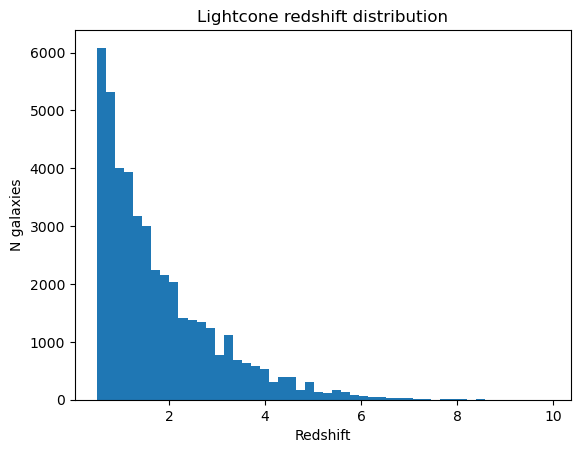

In [2]:
# Generate a lightcone
lc_file = generate_lightcone(
    area_deg2=1.0,  # 1 square degree
    z_min=0.5,
    z_max=13.0,
    output_file=OUTPUT_DIR / "test_lightcone.h5",
    verbose=True
)

# Load and inspect
with h5py.File(lc_file, 'r') as f:
    print("Keys:", list(f.keys()))
    print("N galaxies:", f.attrs['n_galaxies'])
    z = f['z'][:]
    
plt.hist(z, bins=50)
plt.xlabel('Redshift')
plt.ylabel('N galaxies')
plt.title('Lightcone redshift distribution')
plt.show()

In [1]:
from astropy.cosmology import Planck15 as cosmo

for z in [0.0, 0.1, 0.5, 1.0, 2.0, 5.0]:
    L_unit = cosmo.kpc_comoving_per_arcmin(z).to('Mpc / degree')
    A = (L_unit * 1.0**0.5).value  # 1 deg^2
    print(f"z={z}: 1 deg² = {A:.1f} Mpc, box is 25 Mpc, A > box? {A > 25}")

z=0.0: 1 deg² = 0.0 Mpc, box is 25 Mpc, A > box? False
z=0.1: 1 deg² = 7.5 Mpc, box is 25 Mpc, A > box? False
z=0.5: 1 deg² = 34.0 Mpc, box is 25 Mpc, A > box? True
z=1.0: 1 deg² = 59.3 Mpc, box is 25 Mpc, A > box? True
z=2.0: 1 deg² = 92.7 Mpc, box is 25 Mpc, A > box? True
z=5.0: 1 deg² = 138.8 Mpc, box is 25 Mpc, A > box? True


In [ ]:
# Load the lightcone
with h5py.File(OUTPUT_DIR / "test_lightcone.h5", 'r') as f:
    lc_z = f['z'][:]
    lc_snap = f['snap'][:]
    lc_idx = f['galaxy_index'][:]
    lc_stellar_mass = f['stellar_mass'][:]

print(f"Lightcone has {len(lc_z)} galaxies")

Lightcone has 44133 galaxies


In [4]:
# Function to compute apparent magnitude from absolute magnitude
def abs_to_app_mag(abs_mag, z):
    """Convert absolute magnitude to apparent magnitude at redshift z."""
    d_L = cosmo.luminosity_distance(z).to('pc').value  # in parsecs
    distance_modulus = 5 * np.log10(d_L / 10)  # 10 pc is the reference
    return abs_mag + distance_modulus


def flux_from_mag(mag):
    """Convert AB magnitude to flux (arbitrary units, but consistent)."""
    return 10**(-0.4 * mag)


def mag_from_flux(flux):
    """Convert flux back to AB magnitude."""
    return -2.5 * np.log10(flux)

In [5]:
# Now loop through lightcone galaxies and compute SEDs
# Group by snapshot to avoid reloading Caesar files

from collections import defaultdict

# Group galaxies by snapshot
snap_groups = defaultdict(list)
for i, (snap, idx, z) in enumerate(zip(lc_snap, lc_idx, lc_z)):
    snap_groups[snap].append((i, idx, z))

print(f"Galaxies spread across {len(snap_groups)} snapshots")

Galaxies spread across 106 snapshots


In [8]:
from astropy.cosmology import Planck15 as cosmo

# Initialize FSPS
sp = fsps.StellarPopulation(
    zcontinuous=1,
    sfh=0,  # SSP
    logzsol=0.0,
    dust_type=2,
)

# Get wavelength grid
wave = sp.wavelengths  # Angstroms

# Store all apparent-magnitude SEDs
all_app_seds = []  # List of (wavelength, flux) for each galaxy

for snap_num in sorted(snap_groups.keys()):
    galaxies_in_snap = snap_groups[snap_num]
    
    # Load Caesar catalogue for this snapshot
    cat_path = CAT_DIR / f"m25n256_{snap_num:03d}.hdf5"
    obj = caesar.load(str(cat_path))
    
    print(f"Processing snap {snap_num}: {len(galaxies_in_snap)} galaxies")
    
    for lc_i, gal_idx, gal_z in galaxies_in_snap:
        gal = obj.galaxies[gal_idx]
        
        # Get galaxy properties for FSPS
        stellar_mass = gal.masses['stellar'].value  # Solar masses
        metallicity = gal.metallicities['stellar']  # Mass-weighted Z
        
        # Simple approach: use mass-weighted age
        # (You might have a more sophisticated method from previous weeks)
        age_gyr = cosmo.age(gal_z).value  # Age of universe at this z
        
        # Set FSPS parameters
        sp.params['logzsol'] = np.log10(metallicity / 0.0142)  # Solar Z = 0.0142
        sp.params['tage'] = age_gyr
        
        # Get absolute magnitude SED (AB mags)
        mags_abs = sp.get_mags(bands=None)  # Returns spectrum in AB mags
        
        # Actually, get the spectrum in Lsun/Hz, then convert
        # sp.get_spectrum() returns (wave, spec) where spec is Lsun/Hz
        wave, spec_Lsun_Hz = sp.get_spectrum(tage=age_gyr)
        
        # Scale by stellar mass (FSPS assumes 1 Msun)
        spec_Lsun_Hz *= stellar_mass
        
        # Convert Lsun/Hz to flux at observer (erg/s/cm²/Hz)
        d_L = cosmo.luminosity_distance(gal_z).to('cm').value
        Lsun_erg_s = 3.828e33  # erg/s
        spec_flux = spec_Lsun_Hz * Lsun_erg_s / (4 * np.pi * d_L**2)
        
        # Apply redshift to wavelengths
        wave_observed = wave * (1 + gal_z)
        
        all_app_seds.append((wave_observed, spec_flux, gal_z))

print(f"Computed SEDs for {len(all_app_seds)} galaxies")

yt : [INFO     ] 2026-01-27 17:55:49,506 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_019.hdf5
yt : [INFO     ] 2026-01-27 17:55:49,522 Found 83 halos
yt : [INFO     ] 2026-01-27 17:55:49,526 Found 1 galaxies


Processing snap 19: 1 galaxies


yt : [INFO     ] 2026-01-27 17:56:11,121 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_020.hdf5
yt : [INFO     ] 2026-01-27 17:56:11,128 Found 126 halos
yt : [INFO     ] 2026-01-27 17:56:11,129 Found 2 galaxies


Processing snap 20: 2 galaxies


yt : [INFO     ] 2026-01-27 17:56:33,008 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_021.hdf5
yt : [INFO     ] 2026-01-27 17:56:33,015 Found 166 halos
yt : [INFO     ] 2026-01-27 17:56:33,017 Found 2 galaxies
yt : [INFO     ] 2026-01-27 17:56:33,212 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_022.hdf5


Processing snap 21: 2 galaxies


yt : [INFO     ] 2026-01-27 17:56:33,219 Found 227 halos
yt : [INFO     ] 2026-01-27 17:56:33,221 Found 3 galaxies


Processing snap 22: 3 galaxies


yt : [INFO     ] 2026-01-27 17:56:33,510 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_023.hdf5
yt : [INFO     ] 2026-01-27 17:56:33,517 Found 303 halos
yt : [INFO     ] 2026-01-27 17:56:33,519 Found 3 galaxies


Processing snap 23: 3 galaxies


yt : [INFO     ] 2026-01-27 17:56:33,804 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_024.hdf5
yt : [INFO     ] 2026-01-27 17:56:33,811 Found 377 halos
yt : [INFO     ] 2026-01-27 17:56:33,813 Found 4 galaxies


Processing snap 24: 4 galaxies


yt : [INFO     ] 2026-01-27 17:56:34,194 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_025.hdf5
yt : [INFO     ] 2026-01-27 17:56:34,201 Found 489 halos
yt : [INFO     ] 2026-01-27 17:56:34,203 Found 6 galaxies


Processing snap 25: 6 galaxies


yt : [INFO     ] 2026-01-27 17:56:34,787 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_026.hdf5
yt : [INFO     ] 2026-01-27 17:56:34,795 Found 602 halos
yt : [INFO     ] 2026-01-27 17:56:34,797 Found 9 galaxies


Processing snap 26: 9 galaxies


yt : [INFO     ] 2026-01-27 17:56:35,642 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_027.hdf5
yt : [INFO     ] 2026-01-27 17:56:35,649 Found 738 halos
yt : [INFO     ] 2026-01-27 17:56:35,652 Found 11 galaxies


Processing snap 27: 11 galaxies


yt : [INFO     ] 2026-01-27 17:56:36,674 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_028.hdf5
yt : [INFO     ] 2026-01-27 17:56:36,681 Found 848 halos
yt : [INFO     ] 2026-01-27 17:56:36,683 Found 13 galaxies


Processing snap 28: 13 galaxies


yt : [INFO     ] 2026-01-27 17:56:37,914 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_029.hdf5
yt : [INFO     ] 2026-01-27 17:56:37,921 Found 1032 halos
yt : [INFO     ] 2026-01-27 17:56:37,923 Found 18 galaxies


Processing snap 29: 18 galaxies


yt : [INFO     ] 2026-01-27 17:56:39,621 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_030.hdf5
yt : [INFO     ] 2026-01-27 17:56:39,630 Found 1239 halos
yt : [INFO     ] 2026-01-27 17:56:39,632 Found 22 galaxies


Processing snap 30: 22 galaxies


yt : [INFO     ] 2026-01-27 17:56:41,694 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_031.hdf5
yt : [INFO     ] 2026-01-27 17:56:41,701 Found 1431 halos
yt : [INFO     ] 2026-01-27 17:56:41,702 Found 27 galaxies


Processing snap 31: 27 galaxies


yt : [INFO     ] 2026-01-27 17:56:44,217 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_032.hdf5
yt : [INFO     ] 2026-01-27 17:56:44,225 Found 1641 halos
yt : [INFO     ] 2026-01-27 17:56:44,227 Found 34 galaxies


Processing snap 32: 34 galaxies


yt : [INFO     ] 2026-01-27 17:56:57,833 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_033.hdf5
yt : [INFO     ] 2026-01-27 17:56:57,842 Found 1849 halos
yt : [INFO     ] 2026-01-27 17:56:57,845 Found 40 galaxies


Processing snap 33: 40 galaxies


yt : [INFO     ] 2026-01-27 17:57:01,676 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_034.hdf5
yt : [INFO     ] 2026-01-27 17:57:01,684 Found 2082 halos
yt : [INFO     ] 2026-01-27 17:57:01,686 Found 53 galaxies


Processing snap 34: 53 galaxies


yt : [INFO     ] 2026-01-27 17:57:06,540 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_035.hdf5
yt : [INFO     ] 2026-01-27 17:57:06,547 Found 2355 halos
yt : [INFO     ] 2026-01-27 17:57:06,549 Found 62 galaxies


Processing snap 35: 62 galaxies


yt : [INFO     ] 2026-01-27 17:57:12,243 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_036.hdf5
yt : [INFO     ] 2026-01-27 17:57:12,251 Found 2609 halos
yt : [INFO     ] 2026-01-27 17:57:12,253 Found 76 galaxies


Processing snap 36: 76 galaxies


yt : [INFO     ] 2026-01-27 17:57:19,238 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_037.hdf5
yt : [INFO     ] 2026-01-27 17:57:19,246 Found 2885 halos
yt : [INFO     ] 2026-01-27 17:57:19,248 Found 87 galaxies


Processing snap 37: 87 galaxies


yt : [INFO     ] 2026-01-27 17:57:27,201 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_038.hdf5
yt : [INFO     ] 2026-01-27 17:57:27,209 Found 3186 halos
yt : [INFO     ] 2026-01-27 17:57:27,210 Found 97 galaxies


Processing snap 38: 97 galaxies


yt : [INFO     ] 2026-01-27 17:57:36,061 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_039.hdf5
yt : [INFO     ] 2026-01-27 17:57:36,068 Found 3440 halos
yt : [INFO     ] 2026-01-27 17:57:36,070 Found 108 galaxies


Processing snap 39: 108 galaxies


yt : [INFO     ] 2026-01-27 17:57:46,021 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_040.hdf5
yt : [INFO     ] 2026-01-27 17:57:46,029 Found 3717 halos
yt : [INFO     ] 2026-01-27 17:57:46,031 Found 110 galaxies


Processing snap 40: 110 galaxies


yt : [INFO     ] 2026-01-27 17:57:56,096 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_041.hdf5
yt : [INFO     ] 2026-01-27 17:57:56,103 Found 3981 halos
yt : [INFO     ] 2026-01-27 17:57:56,104 Found 127 galaxies


Processing snap 41: 127 galaxies


yt : [INFO     ] 2026-01-27 17:58:07,705 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_042.hdf5
yt : [INFO     ] 2026-01-27 17:58:07,713 Found 4271 halos
yt : [INFO     ] 2026-01-27 17:58:07,716 Found 141 galaxies


Processing snap 42: 141 galaxies


yt : [INFO     ] 2026-01-27 17:58:20,627 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_043.hdf5
yt : [INFO     ] 2026-01-27 17:58:20,635 Found 4554 halos
yt : [INFO     ] 2026-01-27 17:58:20,636 Found 160 galaxies


Processing snap 43: 160 galaxies


yt : [INFO     ] 2026-01-27 17:58:35,377 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_044.hdf5
yt : [INFO     ] 2026-01-27 17:58:35,386 Found 4831 halos
yt : [INFO     ] 2026-01-27 17:58:35,387 Found 174 galaxies


Processing snap 44: 174 galaxies


yt : [INFO     ] 2026-01-27 17:58:51,241 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_045.hdf5
yt : [INFO     ] 2026-01-27 17:58:51,248 Found 5113 halos
yt : [INFO     ] 2026-01-27 17:58:51,250 Found 186 galaxies


Processing snap 45: 186 galaxies


yt : [INFO     ] 2026-01-27 17:59:08,237 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_046.hdf5
yt : [INFO     ] 2026-01-27 17:59:08,245 Found 5311 halos
yt : [INFO     ] 2026-01-27 17:59:08,247 Found 203 galaxies


Processing snap 46: 203 galaxies


yt : [INFO     ] 2026-01-27 17:59:38,050 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_047.hdf5
yt : [INFO     ] 2026-01-27 17:59:38,057 Found 5578 halos
yt : [INFO     ] 2026-01-27 17:59:38,059 Found 217 galaxies


Processing snap 47: 217 galaxies


yt : [INFO     ] 2026-01-27 17:59:57,990 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_048.hdf5
yt : [INFO     ] 2026-01-27 17:59:57,998 Found 5780 halos
yt : [INFO     ] 2026-01-27 17:59:57,999 Found 235 galaxies


Processing snap 48: 235 galaxies


yt : [INFO     ] 2026-01-27 18:00:19,582 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_049.hdf5
yt : [INFO     ] 2026-01-27 18:00:19,589 Found 6054 halos
yt : [INFO     ] 2026-01-27 18:00:19,591 Found 244 galaxies


Processing snap 49: 244 galaxies


yt : [INFO     ] 2026-01-27 18:00:52,883 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_050.hdf5
yt : [INFO     ] 2026-01-27 18:00:52,891 Found 6251 halos
yt : [INFO     ] 2026-01-27 18:00:52,893 Found 257 galaxies


Processing snap 50: 257 galaxies


yt : [INFO     ] 2026-01-27 18:01:16,453 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_051.hdf5
yt : [INFO     ] 2026-01-27 18:01:16,461 Found 6452 halos
yt : [INFO     ] 2026-01-27 18:01:16,463 Found 276 galaxies


Processing snap 51: 276 galaxies


yt : [INFO     ] 2026-01-27 18:01:41,802 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_052.hdf5
yt : [INFO     ] 2026-01-27 18:01:41,809 Found 6664 halos
yt : [INFO     ] 2026-01-27 18:01:41,811 Found 290 galaxies


Processing snap 52: 290 galaxies


yt : [INFO     ] 2026-01-27 20:38:11,529 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_053.hdf5
yt : [INFO     ] 2026-01-27 20:38:11,536 Found 6837 halos
yt : [INFO     ] 2026-01-27 20:38:11,538 Found 299 galaxies


Processing snap 53: 299 galaxies


yt : [INFO     ] 2026-01-27 20:38:38,750 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_054.hdf5
yt : [INFO     ] 2026-01-27 20:38:38,758 Found 6994 halos
yt : [INFO     ] 2026-01-27 20:38:38,760 Found 310 galaxies


Processing snap 54: 310 galaxies


yt : [INFO     ] 2026-01-27 20:39:07,020 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_055.hdf5
yt : [INFO     ] 2026-01-27 20:39:07,028 Found 7188 halos
yt : [INFO     ] 2026-01-27 20:39:07,030 Found 327 galaxies


Processing snap 55: 327 galaxies


yt : [INFO     ] 2026-01-27 20:39:36,908 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_056.hdf5
yt : [INFO     ] 2026-01-27 20:39:36,917 Found 7336 halos
yt : [INFO     ] 2026-01-27 20:39:36,920 Found 338 galaxies


Processing snap 56: 338 galaxies


yt : [INFO     ] 2026-01-27 20:40:07,878 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_057.hdf5
yt : [INFO     ] 2026-01-27 20:40:07,886 Found 7482 halos
yt : [INFO     ] 2026-01-27 20:40:07,888 Found 348 galaxies


Processing snap 57: 348 galaxies


yt : [INFO     ] 2026-01-27 20:40:49,990 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_058.hdf5
yt : [INFO     ] 2026-01-27 20:40:49,997 Found 7663 halos
yt : [INFO     ] 2026-01-27 20:40:49,999 Found 359 galaxies


Processing snap 58: 359 galaxies


yt : [INFO     ] 2026-01-27 20:41:23,644 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_059.hdf5
yt : [INFO     ] 2026-01-27 20:41:23,652 Found 7755 halos
yt : [INFO     ] 2026-01-27 20:41:23,653 Found 373 galaxies


Processing snap 59: 373 galaxies


yt : [INFO     ] 2026-01-27 20:41:57,984 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_060.hdf5
yt : [INFO     ] 2026-01-27 20:41:57,991 Found 7867 halos
yt : [INFO     ] 2026-01-27 20:41:57,993 Found 387 galaxies


Processing snap 60: 387 galaxies


yt : [INFO     ] 2026-01-27 20:42:33,409 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_061.hdf5
yt : [INFO     ] 2026-01-27 20:42:33,417 Found 7963 halos
yt : [INFO     ] 2026-01-27 20:42:33,418 Found 383 galaxies


Processing snap 61: 383 galaxies


yt : [INFO     ] 2026-01-27 20:43:08,313 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_062.hdf5
yt : [INFO     ] 2026-01-27 20:43:08,321 Found 8109 halos
yt : [INFO     ] 2026-01-27 20:43:08,322 Found 398 galaxies


Processing snap 62: 398 galaxies


yt : [INFO     ] 2026-01-27 20:43:44,282 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_063.hdf5
yt : [INFO     ] 2026-01-27 20:43:44,288 Found 8147 halos
yt : [INFO     ] 2026-01-27 20:43:44,290 Found 401 galaxies


Processing snap 63: 401 galaxies


yt : [INFO     ] 2026-01-27 20:44:20,562 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_064.hdf5
yt : [INFO     ] 2026-01-27 20:44:20,569 Found 8235 halos
yt : [INFO     ] 2026-01-27 20:44:20,571 Found 424 galaxies


Processing snap 64: 424 galaxies


yt : [INFO     ] 2026-01-27 20:44:58,793 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_065.hdf5
yt : [INFO     ] 2026-01-27 20:44:58,800 Found 8253 halos
yt : [INFO     ] 2026-01-27 20:44:58,802 Found 420 galaxies


Processing snap 65: 420 galaxies


yt : [INFO     ] 2026-01-27 20:45:36,597 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_066.hdf5
yt : [INFO     ] 2026-01-27 20:45:36,604 Found 8377 halos
yt : [INFO     ] 2026-01-27 20:45:36,606 Found 440 galaxies


Processing snap 66: 440 galaxies


yt : [INFO     ] 2026-01-27 20:46:16,357 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_067.hdf5
yt : [INFO     ] 2026-01-27 20:46:16,364 Found 8469 halos
yt : [INFO     ] 2026-01-27 20:46:16,365 Found 453 galaxies


Processing snap 67: 453 galaxies


yt : [INFO     ] 2026-01-27 20:46:57,442 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_068.hdf5
yt : [INFO     ] 2026-01-27 20:46:57,450 Found 8514 halos
yt : [INFO     ] 2026-01-27 20:46:57,644 Found 446 galaxies


Processing snap 68: 446 galaxies


yt : [INFO     ] 2026-01-27 20:47:37,992 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_069.hdf5
yt : [INFO     ] 2026-01-27 20:47:38,000 Found 8579 halos
yt : [INFO     ] 2026-01-27 20:47:38,001 Found 456 galaxies


Processing snap 69: 456 galaxies


yt : [INFO     ] 2026-01-27 20:48:19,638 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_070.hdf5
yt : [INFO     ] 2026-01-27 20:48:19,646 Found 8687 halos
yt : [INFO     ] 2026-01-27 20:48:19,648 Found 454 galaxies


Processing snap 70: 454 galaxies


yt : [INFO     ] 2026-01-27 20:49:00,781 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_071.hdf5
yt : [INFO     ] 2026-01-27 20:49:00,789 Found 8716 halos
yt : [INFO     ] 2026-01-27 20:49:00,791 Found 467 galaxies


Processing snap 71: 467 galaxies


yt : [INFO     ] 2026-01-27 20:49:43,017 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_072.hdf5
yt : [INFO     ] 2026-01-27 20:49:43,024 Found 8790 halos
yt : [INFO     ] 2026-01-27 20:49:43,026 Found 465 galaxies


Processing snap 72: 465 galaxies


yt : [INFO     ] 2026-01-27 20:50:25,015 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_073.hdf5
yt : [INFO     ] 2026-01-27 20:50:25,022 Found 8819 halos
yt : [INFO     ] 2026-01-27 20:50:25,024 Found 476 galaxies


Processing snap 73: 476 galaxies


yt : [INFO     ] 2026-01-27 20:51:08,017 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_074.hdf5
yt : [INFO     ] 2026-01-27 20:51:08,025 Found 8861 halos
yt : [INFO     ] 2026-01-27 20:51:08,026 Found 477 galaxies


Processing snap 74: 477 galaxies


yt : [INFO     ] 2026-01-27 20:51:51,532 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_075.hdf5
yt : [INFO     ] 2026-01-27 20:51:51,539 Found 8897 halos
yt : [INFO     ] 2026-01-27 20:51:51,540 Found 495 galaxies


Processing snap 75: 495 galaxies


yt : [INFO     ] 2026-01-27 20:52:36,876 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_076.hdf5
yt : [INFO     ] 2026-01-27 20:52:36,884 Found 8869 halos
yt : [INFO     ] 2026-01-27 20:52:36,886 Found 505 galaxies


Processing snap 76: 505 galaxies


yt : [INFO     ] 2026-01-27 20:53:23,007 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_077.hdf5
yt : [INFO     ] 2026-01-27 20:53:23,014 Found 8898 halos
yt : [INFO     ] 2026-01-27 20:53:23,016 Found 507 galaxies


Processing snap 77: 507 galaxies


yt : [INFO     ] 2026-01-27 20:54:09,067 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_078.hdf5
yt : [INFO     ] 2026-01-27 20:54:09,076 Found 8893 halos
yt : [INFO     ] 2026-01-27 20:54:09,077 Found 530 galaxies


Processing snap 78: 530 galaxies


yt : [INFO     ] 2026-01-27 20:54:57,592 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_079.hdf5
yt : [INFO     ] 2026-01-27 20:54:57,600 Found 8900 halos
yt : [INFO     ] 2026-01-27 20:54:57,602 Found 519 galaxies


Processing snap 79: 519 galaxies


yt : [INFO     ] 2026-01-27 20:55:45,053 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_080.hdf5
yt : [INFO     ] 2026-01-27 20:55:45,060 Found 8878 halos
yt : [INFO     ] 2026-01-27 20:55:45,062 Found 536 galaxies


Processing snap 80: 536 galaxies


yt : [INFO     ] 2026-01-27 20:56:33,957 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_081.hdf5
yt : [INFO     ] 2026-01-27 20:56:33,964 Found 8880 halos
yt : [INFO     ] 2026-01-27 20:56:33,966 Found 539 galaxies


Processing snap 81: 539 galaxies


yt : [INFO     ] 2026-01-27 20:57:23,277 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_082.hdf5
yt : [INFO     ] 2026-01-27 20:57:23,285 Found 8908 halos
yt : [INFO     ] 2026-01-27 20:57:23,287 Found 555 galaxies


Processing snap 82: 555 galaxies


yt : [INFO     ] 2026-01-27 20:58:14,144 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_083.hdf5
yt : [INFO     ] 2026-01-27 20:58:14,152 Found 8905 halos
yt : [INFO     ] 2026-01-27 20:58:14,154 Found 551 galaxies


Processing snap 83: 551 galaxies


yt : [INFO     ] 2026-01-27 20:59:04,416 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_084.hdf5
yt : [INFO     ] 2026-01-27 20:59:04,424 Found 8869 halos
yt : [INFO     ] 2026-01-27 20:59:04,425 Found 549 galaxies


Processing snap 84: 549 galaxies


yt : [INFO     ] 2026-01-27 20:59:54,274 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_085.hdf5
yt : [INFO     ] 2026-01-27 20:59:54,282 Found 8903 halos
yt : [INFO     ] 2026-01-27 20:59:54,284 Found 574 galaxies


Processing snap 85: 574 galaxies


yt : [INFO     ] 2026-01-27 21:00:46,487 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_086.hdf5
yt : [INFO     ] 2026-01-27 21:00:46,494 Found 8892 halos
yt : [INFO     ] 2026-01-27 21:00:46,495 Found 569 galaxies


Processing snap 86: 569 galaxies


yt : [INFO     ] 2026-01-27 21:01:38,586 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_087.hdf5
yt : [INFO     ] 2026-01-27 21:01:38,593 Found 8890 halos
yt : [INFO     ] 2026-01-27 21:01:38,595 Found 591 galaxies


Processing snap 87: 591 galaxies


yt : [INFO     ] 2026-01-27 21:02:32,328 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_088.hdf5
yt : [INFO     ] 2026-01-27 21:02:32,335 Found 8836 halos
yt : [INFO     ] 2026-01-27 21:02:32,337 Found 594 galaxies


Processing snap 88: 594 galaxies


yt : [INFO     ] 2026-01-27 21:03:26,149 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_089.hdf5
yt : [INFO     ] 2026-01-27 21:03:26,156 Found 8913 halos
yt : [INFO     ] 2026-01-27 21:03:26,157 Found 603 galaxies


Processing snap 89: 603 galaxies


yt : [INFO     ] 2026-01-27 21:04:21,043 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_090.hdf5
yt : [INFO     ] 2026-01-27 21:04:21,050 Found 8877 halos
yt : [INFO     ] 2026-01-27 21:04:21,052 Found 610 galaxies


Processing snap 90: 610 galaxies


yt : [INFO     ] 2026-01-27 21:05:16,422 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_091.hdf5
yt : [INFO     ] 2026-01-27 21:05:16,429 Found 8847 halos
yt : [INFO     ] 2026-01-27 21:05:16,430 Found 601 galaxies


Processing snap 91: 601 galaxies


yt : [INFO     ] 2026-01-27 21:06:10,589 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_092.hdf5
yt : [INFO     ] 2026-01-27 21:06:10,597 Found 8875 halos
yt : [INFO     ] 2026-01-27 21:06:10,599 Found 620 galaxies


Processing snap 92: 620 galaxies


yt : [INFO     ] 2026-01-27 21:07:06,713 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_093.hdf5
yt : [INFO     ] 2026-01-27 21:07:06,721 Found 8817 halos
yt : [INFO     ] 2026-01-27 21:07:06,722 Found 642 galaxies


Processing snap 93: 642 galaxies


yt : [INFO     ] 2026-01-27 21:08:05,181 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_094.hdf5
yt : [INFO     ] 2026-01-27 21:08:05,188 Found 8803 halos
yt : [INFO     ] 2026-01-27 21:08:05,190 Found 641 galaxies


Processing snap 94: 641 galaxies


yt : [INFO     ] 2026-01-27 21:09:03,228 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_095.hdf5
yt : [INFO     ] 2026-01-27 21:09:03,236 Found 8769 halos
yt : [INFO     ] 2026-01-27 21:09:03,238 Found 633 galaxies


Processing snap 95: 633 galaxies


yt : [INFO     ] 2026-01-27 21:10:00,569 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_096.hdf5
yt : [INFO     ] 2026-01-27 21:10:00,576 Found 8818 halos
yt : [INFO     ] 2026-01-27 21:10:00,578 Found 638 galaxies


Processing snap 96: 638 galaxies


yt : [INFO     ] 2026-01-27 21:10:58,039 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_097.hdf5
yt : [INFO     ] 2026-01-27 21:10:58,046 Found 8795 halos
yt : [INFO     ] 2026-01-27 21:10:58,048 Found 642 galaxies


Processing snap 97: 642 galaxies


yt : [INFO     ] 2026-01-27 21:11:56,037 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_098.hdf5
yt : [INFO     ] 2026-01-27 21:11:56,045 Found 8779 halos
yt : [INFO     ] 2026-01-27 21:11:56,046 Found 647 galaxies


Processing snap 98: 647 galaxies


yt : [INFO     ] 2026-01-27 21:12:54,560 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_099.hdf5
yt : [INFO     ] 2026-01-27 21:12:54,567 Found 8781 halos
yt : [INFO     ] 2026-01-27 21:12:54,569 Found 648 galaxies


Processing snap 99: 648 galaxies


yt : [INFO     ] 2026-01-27 21:13:53,172 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_100.hdf5
yt : [INFO     ] 2026-01-27 21:13:53,179 Found 8752 halos
yt : [INFO     ] 2026-01-27 21:13:53,181 Found 656 galaxies


Processing snap 100: 656 galaxies


yt : [INFO     ] 2026-01-27 21:14:52,617 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_101.hdf5
yt : [INFO     ] 2026-01-27 21:14:52,625 Found 8743 halos
yt : [INFO     ] 2026-01-27 21:14:52,627 Found 673 galaxies


Processing snap 101: 673 galaxies


yt : [INFO     ] 2026-01-27 21:15:53,780 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_102.hdf5
yt : [INFO     ] 2026-01-27 21:15:53,787 Found 8714 halos
yt : [INFO     ] 2026-01-27 21:15:53,788 Found 664 galaxies


Processing snap 102: 664 galaxies


yt : [INFO     ] 2026-01-27 21:16:54,949 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_103.hdf5
yt : [INFO     ] 2026-01-27 21:16:54,956 Found 8700 halos
yt : [INFO     ] 2026-01-27 21:16:54,958 Found 661 galaxies


Processing snap 103: 661 galaxies


yt : [INFO     ] 2026-01-27 21:17:55,012 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_104.hdf5
yt : [INFO     ] 2026-01-27 21:17:55,020 Found 8689 halos
yt : [INFO     ] 2026-01-27 21:17:55,022 Found 665 galaxies


Processing snap 104: 665 galaxies


yt : [INFO     ] 2026-01-27 21:18:55,464 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_105.hdf5
yt : [INFO     ] 2026-01-27 21:18:55,471 Found 8666 halos
yt : [INFO     ] 2026-01-27 21:18:55,473 Found 655 galaxies


Processing snap 105: 655 galaxies


yt : [INFO     ] 2026-01-27 21:19:55,152 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_106.hdf5
yt : [INFO     ] 2026-01-27 21:19:55,159 Found 8641 halos
yt : [INFO     ] 2026-01-27 21:19:55,161 Found 668 galaxies


Processing snap 106: 668 galaxies


yt : [INFO     ] 2026-01-27 21:20:56,175 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_107.hdf5
yt : [INFO     ] 2026-01-27 21:20:56,182 Found 8544 halos
yt : [INFO     ] 2026-01-27 21:20:56,185 Found 673 galaxies


Processing snap 107: 673 galaxies


yt : [INFO     ] 2026-01-27 21:21:57,647 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_108.hdf5
yt : [INFO     ] 2026-01-27 21:21:57,654 Found 8535 halos
yt : [INFO     ] 2026-01-27 21:21:57,657 Found 675 galaxies


Processing snap 108: 675 galaxies


yt : [INFO     ] 2026-01-27 21:22:59,148 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_109.hdf5
yt : [INFO     ] 2026-01-27 21:22:59,155 Found 8520 halos
yt : [INFO     ] 2026-01-27 21:22:59,157 Found 676 galaxies


Processing snap 109: 676 galaxies


yt : [INFO     ] 2026-01-27 21:24:00,638 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_110.hdf5
yt : [INFO     ] 2026-01-27 21:24:00,649 Found 8468 halos
yt : [INFO     ] 2026-01-27 21:24:00,658 Found 686 galaxies


Processing snap 110: 686 galaxies


yt : [INFO     ] 2026-01-27 21:25:02,888 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_111.hdf5
yt : [INFO     ] 2026-01-27 21:25:02,898 Found 8474 halos
yt : [INFO     ] 2026-01-27 21:25:02,907 Found 684 galaxies


Processing snap 111: 684 galaxies


yt : [INFO     ] 2026-01-27 21:26:05,726 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_112.hdf5
yt : [INFO     ] 2026-01-27 21:26:05,737 Found 8459 halos
yt : [INFO     ] 2026-01-27 21:26:05,747 Found 701 galaxies


Processing snap 112: 701 galaxies


yt : [INFO     ] 2026-01-27 21:27:09,663 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_113.hdf5
yt : [INFO     ] 2026-01-27 21:27:09,674 Found 8450 halos
yt : [INFO     ] 2026-01-27 21:27:09,684 Found 697 galaxies


Processing snap 113: 697 galaxies


yt : [INFO     ] 2026-01-27 21:28:13,060 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_114.hdf5
yt : [INFO     ] 2026-01-27 21:28:13,071 Found 8429 halos
yt : [INFO     ] 2026-01-27 21:28:13,081 Found 693 galaxies


Processing snap 114: 693 galaxies


yt : [INFO     ] 2026-01-27 21:29:16,201 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_115.hdf5
yt : [INFO     ] 2026-01-27 21:29:16,212 Found 8374 halos
yt : [INFO     ] 2026-01-27 21:29:16,223 Found 697 galaxies


Processing snap 115: 697 galaxies


yt : [INFO     ] 2026-01-27 21:30:19,839 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_116.hdf5
yt : [INFO     ] 2026-01-27 21:30:19,850 Found 8346 halos
yt : [INFO     ] 2026-01-27 21:30:19,860 Found 700 galaxies


Processing snap 116: 700 galaxies


yt : [INFO     ] 2026-01-27 21:31:23,656 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_117.hdf5
yt : [INFO     ] 2026-01-27 21:31:23,667 Found 8336 halos
yt : [INFO     ] 2026-01-27 21:31:23,678 Found 716 galaxies


Processing snap 117: 716 galaxies


yt : [INFO     ] 2026-01-27 21:32:28,580 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_118.hdf5
yt : [INFO     ] 2026-01-27 21:32:28,592 Found 8313 halos
yt : [INFO     ] 2026-01-27 21:32:28,602 Found 722 galaxies


Processing snap 118: 722 galaxies


yt : [INFO     ] 2026-01-27 21:33:33,979 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_119.hdf5
yt : [INFO     ] 2026-01-27 21:33:33,990 Found 8258 halos
yt : [INFO     ] 2026-01-27 21:33:34,000 Found 725 galaxies


Processing snap 119: 725 galaxies


yt : [INFO     ] 2026-01-27 21:34:39,583 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_120.hdf5
yt : [INFO     ] 2026-01-27 21:34:39,594 Found 8215 halos
yt : [INFO     ] 2026-01-27 21:34:39,603 Found 725 galaxies


Processing snap 120: 725 galaxies


yt : [INFO     ] 2026-01-27 21:35:45,182 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_121.hdf5
yt : [INFO     ] 2026-01-27 21:35:45,193 Found 8186 halos
yt : [INFO     ] 2026-01-27 21:35:45,201 Found 752 galaxies


Processing snap 121: 752 galaxies


yt : [INFO     ] 2026-01-27 21:36:53,345 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_122.hdf5
yt : [INFO     ] 2026-01-27 21:36:53,356 Found 8169 halos
yt : [INFO     ] 2026-01-27 21:36:53,365 Found 749 galaxies


Processing snap 122: 749 galaxies


yt : [INFO     ] 2026-01-27 21:38:01,625 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_123.hdf5
yt : [INFO     ] 2026-01-27 21:38:01,636 Found 8172 halos
yt : [INFO     ] 2026-01-27 21:38:01,646 Found 748 galaxies


Processing snap 123: 728 galaxies


yt : [INFO     ] 2026-01-27 21:39:07,737 Opening /home/sid/Documents/edinburgh/year_4/simba_cosmic_background/data/caesar_catalogues/m25n256/m25n256_124.hdf5
yt : [INFO     ] 2026-01-27 21:39:07,747 Found 8154 halos
yt : [INFO     ] 2026-01-27 21:39:07,756 Found 759 galaxies


Processing snap 124: 754 galaxies
Computed SEDs for 44133 galaxies


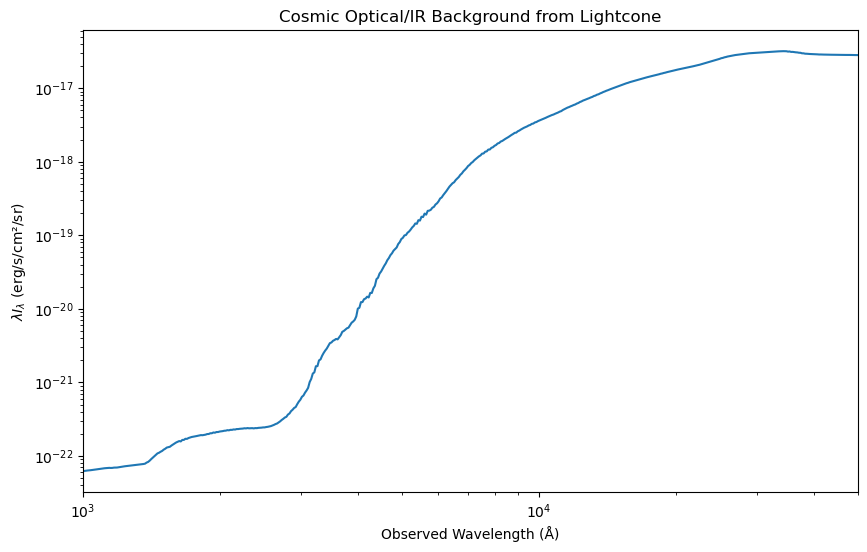

In [9]:
# Now sum all SEDs onto a common wavelength grid
# Need to interpolate since each galaxy has different observed wavelengths

# Define common observed wavelength grid
wave_common = np.logspace(np.log10(1000), np.log10(50000), 500)  # 1000 Å to 5 μm

total_flux = np.zeros_like(wave_common)

for wave_obs, flux, z in all_app_seds:
    # Interpolate onto common grid
    flux_interp = np.interp(wave_common, wave_obs, flux, left=0, right=0)
    total_flux += flux_interp

# Convert to surface brightness (per steradian)
# 1 deg² = (π/180)² steradians
area_sr = (1.0 * np.pi / 180)**2  # 1 deg² in steradians
surface_brightness = total_flux / area_sr  # erg/s/cm²/Hz/sr

# Plot the cosmic SED
plt.figure(figsize=(10, 6))
plt.loglog(wave_common, surface_brightness * wave_common)  # νIν or λIλ
plt.xlabel('Observed Wavelength (Å)')
plt.ylabel(r'$\lambda I_\lambda$ (erg/s/cm²/sr)')
plt.title('Cosmic Optical/IR Background from Lightcone')
plt.xlim(1000, 50000)
plt.show()